# Starting a Spark Session

In [1]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Spark of The Fraudster").getOrCreate()
spark

# Libraries for ML and Visualisation

In [2]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.feature import VectorAssembler, MaxAbsScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import matplotlib.pyplot as plt

# Reading and Investigating the Dataset

In [3]:
df = spark.read.csv("credit_card_fraud.csv", header=True, inferSchema=True)

In [4]:
df.createOrReplaceTempView("fraud_table")

In [5]:
spark.sql("SELECT * FROM fraud_table").show(10)

+----+------------------+-------------------+------------------+------------------+-------------------+-------------------+--------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+------------------+-------------------+-------------------+--------------------+-------------------+------+-----+
|Time|                V1|                 V2|                V3|                V4|                 V5|                 V6|                  V7|                V8|                V9|                V10|               V11|               V12|               V13|               V14|               V15|                V16|                V17|                V18|                V19|                V20|                 V21|          

In [6]:
print(f"Number of columns: {spark.sql("DESCRIBE fraud_table").count()}")

Number of columns: 31


In [7]:
print(f"Number of Non-Fraudulent Observations: {spark.sql("SELECT * FROM fraud_table WHERE Class=0").count()}\n"
      f"Number of Fraudulent Observations: {spark.sql("SELECT * FROM fraud_table WHERE Class=1").count()}\n"
      f"Number of Total Observations: {spark.sql("SELECT * FROM fraud_table").count()}")

Number of Non-Fraudulent Observations: 284315
Number of Fraudulent Observations: 492
Number of Total Observations: 284807


It is evident that the dataset it highly imbalanced

In [8]:
class_stats = spark.sql("""
    SELECT
        Class,
        AVG(Amount) as mean_amount,
        STDDEV(Amount) as stddev_amount,
        MIN(Amount) as min_amount,
        MAX(Amount) as max_amount
    FROM
        fraud_table
    GROUP BY
        Class
""").collect()

for row in class_stats:
    print(f"Class: {row['Class']}")
    print("Mean:", row["mean_amount"])
    print("Standard Deviation:", row["stddev_amount"])
    print("Minimum:", row["min_amount"])
    print("Maximum:", row["max_amount"])

Class: 1
Mean: 122.2113211382114
Standard Deviation: 256.6832882977121
Minimum: 0.0
Maximum: 2125.87
Class: 0
Mean: 88.29102242231271
Standard Deviation: 250.10509222589235
Minimum: 0.0
Maximum: 25691.16


In [9]:
X = [col for col in df.columns if col not in ["Time", "Class"]]
y = df.select("Class")
print(X)
print(y)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
DataFrame[Class: int]


# Preparing the Data for ML Process

In [10]:
vectorizer = VectorAssembler(inputCols=X,
                             outputCol="independent_features")

df_vectorized = vectorizer.transform(df)
df_vectorized.show(10)

+----+------------------+-------------------+------------------+------------------+-------------------+-------------------+--------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+------------------+-------------------+-------------------+--------------------+-------------------+------+-----+--------------------+
|Time|                V1|                 V2|                V3|                V4|                 V5|                 V6|                  V7|                V8|                V9|                V10|               V11|               V12|               V13|               V14|               V15|                V16|                V17|                V18|                V19|                V20|          

In [11]:
df_final = df_vectorized.select("independent_features", "Class")
df_final.show(10)

+--------------------+-----+
|independent_features|Class|
+--------------------+-----+
|[-1.3598071336738...|    0|
|[1.19185711131486...|    0|
|[-1.3583540615982...|    0|
|[-0.9662717115720...|    0|
|[-1.1582330934952...|    0|
|[-0.4259658844124...|    0|
|[1.22965763450793...|    0|
|[-0.6442694423481...|    0|
|[-0.8942860822028...|    0|
|[-0.3382617524257...|    0|
+--------------------+-----+
only showing top 10 rows



In [12]:
df_final_class_1 = df_final.filter(df_final["Class"] == 1)
df_final_class_0 = df_final.filter(df_final["Class"] == 0)
df_final_class_1.show(10)

+--------------------+-----+
|independent_features|Class|
+--------------------+-----+
|[-2.3122265423263...|    1|
|[-3.0435406239976...|    1|
|[-2.3033495675855...|    1|
|[-4.3979744417199...|    1|
|[1.23423504613468...|    1|
|[0.00843036489558...|    1|
|[0.02677922644915...|    1|
|[0.32959433331822...|    1|
|[0.31645900044498...|    1|
|[0.72564573981985...|    1|
+--------------------+-----+
only showing top 10 rows



# Train-Test Splitting and Scaling

Due to the highly imbalanced nature of the dataset, where the number of fraudulent observations comprises only ~0.17%, the fraudulent observations were splitted into 80% for the training set and 20% for the test set.

In [13]:
df_sample_class_1 = df_final_class_1.sample(False, 0.8, seed=123)
df_sample_class_0 = df_final_class_0.sample(False, 0.8, seed=123)
df_train = df_sample_class_1.union(df_sample_class_0)
df_test = df_final.subtract(df_train)

scaler = MaxAbsScaler(inputCol="independent_features",
                       outputCol="scaled_ind_features")

scaler_model = scaler.fit(df_final)
df_train = scaler_model.transform(df_train).drop("independent_features").select(["scaled_ind_features", "Class"])
df_test = scaler_model.transform(df_test).drop("independent_features").select(["scaled_ind_features", "Class"])

# Models

In [14]:
# lr = LogisticRegression(maxIter=10, regParam=0.01, elasticNetParam=0.8)
# 
# max_iter = lr.getMaxIter()
# reg_param = lr.getRegParam()
# elastic_net_param = lr.getElasticNetParam()
# tol = lr.getTol()
# fitIntercept = lr.getFitIntercept()
# threshold = lr.getThreshold()
# print(max_iter, reg_param, elastic_net_param, tol, fitIntercept, threshold)

## Model Training Class

In [15]:
class ModelTrainer:
    def __init__(self):
        self.model_name = None
        self.model_methods = {
            "logistic_regression": self.logistic_regression,
            "random_forest": self.random_forest,
            "gradient_boosted_trees": self.gradient_boosted_trees
        }
        self.model_display_names = {
            "logistic_regression": "Logistic Regression",
            "random_forest": "Random Forest",
            "gradient_boosted_trees": "Gradient Boosted Trees"
        }

    def train_model(self, model_name, train_data, test_data):
        if model_name not in self.model_methods:
            raise ValueError("Invalid model name")
        
        self.model_name = model_name
        train_method = self.model_methods[model_name]
        return train_method(train_data, test_data)

    def get_display_name(self):
        if self.model_name:
            return self.model_display_names.get(self.model_name, self.model_name)
        else:
            return None


    def logistic_regression(self, train_data, test_data):
        train_set = train_data.alias("train_data")
        test_set = test_data.alias("test_data")

        lr = LogisticRegression(featuresCol='scaled_ind_features', labelCol='Class')
        paramGrid = ParamGridBuilder() \
            .addGrid(lr.regParam, 
                [
                lr.getRegParam(),
                lr.getRegParam() + 0.01,
                lr.getRegParam() + 0.05,
                lr.getRegParam() + 0.1
                ]) \
            .addGrid(lr.elasticNetParam, 
                [
                lr.getElasticNetParam(),
                lr.getElasticNetParam() + 0.25,
                lr.getElasticNetParam() + 0.5,
                lr.getElasticNetParam() + 0.75
                ]) \
            .addGrid(lr.maxIter, 
                [
                lr.getMaxIter(),
                int(lr.getMaxIter()*0.80),
                int(lr.getMaxIter()*0.90),
                int(lr.getMaxIter()*1.10),
                int(lr.getMaxIter()*1.20)
                ]) \
            .addGrid(lr.tol, 
                [
                lr.getTol(),
                lr.getTol()*0.80,
                lr.getTol()*0.90,
                lr.getTol()*1.10,
                lr.getTol()*1.20
                ]) \
            .addGrid(lr.threshold, 
                [
                lr.getThreshold(),
                lr.getThreshold()*0.90,
                lr.getThreshold()*1.10
                ]) \
            .build()

        evaluator = BinaryClassificationEvaluator(metricName="areaUnderPR", rawPredictionCol="rawPrediction", labelCol="Class")
        
        cv = CrossValidator(estimator=lr,
                            estimatorParamMaps=paramGrid,
                            evaluator=evaluator)
        
        model = cv.fit(train_set).bestModel

        predictions = model.transform(test_set)

        test_metrics = self.test_metric_calculator(predictions)

        train_metrics = self.train_metric_calculator(model)

        return model, train_metrics, test_metrics, predictions
    
    
    def random_forest(self, train_data, test_data):
        train_set = train_data.alias("train_data")
        test_set = test_data.alias("test_data")

        rf = RandomForestClassifier(featuresCol='scaled_ind_features', labelCol='Class')
        paramGrid = ParamGridBuilder() \
            .addGrid(rf.maxDepth, 
                [
                rf.getMaxDepth(),
                int(rf.getMaxDepth()*1.5),
                int(rf.getMaxDepth()*2),
                int(rf.getMaxDepth()*3)
                ]) \
            .addGrid(rf.numTrees,
                [
                rf.getNumTrees(),
                int(rf.getNumTrees()*0.8),
                int(rf.getNumTrees()*1.25),
                int(rf.getNumTrees()*1.3),
                int(rf.getNumTrees()*1.5)
                ]) \
            .build()

        evaluator = BinaryClassificationEvaluator(metricName="areaUnderPR", rawPredictionCol="rawPrediction", labelCol="Class")
        
        cv = CrossValidator(estimator=rf,
                            estimatorParamMaps=paramGrid,
                            evaluator=evaluator)
        
        model = cv.fit(train_set).bestModel

        predictions = model.transform(test_set)

        test_metrics = self.test_metric_calculator(predictions)

        train_metrics = self.train_metric_calculator(model)

        return model, train_metrics, test_metrics, predictions
    

    def gradient_boosted_trees(self, train_data, test_data):
        train_set = train_data.alias("train_data")
        test_set = test_data.alias("test_data")

        gbt = GBTClassifier(featuresCol='scaled_ind_features', labelCol='Class')
        paramGrid = ParamGridBuilder() \
            .addGrid(gbt.maxDepth, [gbt.getMaxDepth()]) \
            .addGrid(gbt.maxIter, [gbt.getMaxIter()]) \
            .addGrid(gbt.maxBins, [gbt.getMaxBins()]) \
            .build()

        evaluator = BinaryClassificationEvaluator(metricName="areaUnderPR", rawPredictionCol="rawPrediction", labelCol="Class")
        
        cv = CrossValidator(estimator=gbt,
                            estimatorParamMaps=paramGrid,
                            evaluator=evaluator)
        
        model = cv.fit(train_set).bestModel

        predictions = model.transform(test_set)

        test_metrics = self.test_metric_calculator(predictions)

        train_metrics = self.train_metric_calculator(model)

        return model, train_metrics, test_metrics, predictions
            
    
    def train_metric_calculator(self, model): 
        summary = model.summary

        train_metrics = {}

        for i, rate in enumerate(summary.falsePositiveRateByLabel):
            train_metrics[f"False Positive Rate (Label {i})"] = rate

        for i, rate in enumerate(summary.truePositiveRateByLabel):
            train_metrics[f"True Positive Rate (Label {i})"] = rate

        for i, prec in enumerate(summary.precisionByLabel):
            train_metrics[f"Precision (Label {i})"] = prec

        for i, rec in enumerate(summary.recallByLabel):
            train_metrics[f"Recall (Label {i})"] = rec

        for i, f in enumerate(summary.fMeasureByLabel()):
            train_metrics[f"F-measure (Label {i})"] = f

        train_metrics['Accuracy'] = summary.accuracy
        train_metrics['Weighted False Positive Rate'] = summary.weightedFalsePositiveRate
        train_metrics['Weighted True Positive Rate'] = summary.weightedTruePositiveRate
        train_metrics['Weighted F-measure'] = summary.weightedFMeasure()
        train_metrics['Weighted Precision'] = summary.weightedPrecision
        train_metrics['Weighted Recall'] = summary.weightedRecall

        return train_metrics
    

    def test_metric_calculator(self, predictions):
        test_metrics = {}

        true_positive = predictions.filter("prediction = 1 AND Class = 1").count()
        false_positive = predictions.filter("prediction = 1 AND Class = 0").count()
        false_negative = predictions.filter("prediction = 0 AND Class = 1").count()
        true_negative = predictions.filter("prediction = 0 AND Class = 0").count()

        test_metrics['true_positive'] = true_positive
        test_metrics['false_positive'] = false_positive
        test_metrics['false_negative'] = false_negative
        test_metrics['true_negative'] = true_negative

        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) != 0 else 0
        recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) != 0 else 0

        test_metrics['precision'] = precision
        test_metrics['recall'] = recall

        return test_metrics
    
    
    def plot_fraudulent_pie_chart(self, model, test_predictions):
        # Train metrics
        model_display_name = self.get_display_name()

        summary = model.summary

        precision_label_train = {}
        recall_label_train = {}

        for i, prec in enumerate(summary.precisionByLabel):
            precision_label_train[f"label_{i}"] = prec

        for i, rec in enumerate(summary.recallByLabel):
            recall_label_train[f"label_{i}"] = rec

        true_fraudulent_train = precision_label_train["label_1"]
        false_fraudulent_train = 1 - precision_label_train["label_1"]

        identified_fraudulent_train = recall_label_train["label_1"]
        not_identified_fraudulent_train = 1 - recall_label_train["label_1"]

        fraudulent_labels_train = ['True Accusation of Fraud', 'False Accusation of Fraud']
        fraudulent_sizes_train = [true_fraudulent_train, false_fraudulent_train]
        fraudulent_colors_train = ['limegreen', 'crimson']

        identification_labels_train = ['Caught Fraudulent', 'Missed Fraudulent']
        identification_sizes_train = [identified_fraudulent_train, not_identified_fraudulent_train]
        identification_colors_train = ['limegreen', 'crimson']

        # Test metrics
        test_metrics = {}

        true_positive = test_predictions.filter("prediction = 1 AND Class = 1").count()
        false_positive = test_predictions.filter("prediction = 1 AND Class = 0").count()
        false_negative = test_predictions.filter("prediction = 0 AND Class = 1").count()
        true_negative = test_predictions.filter("prediction = 0 AND Class = 0").count()

        test_metrics['true_positive'] = true_positive
        test_metrics['false_positive'] = false_positive
        test_metrics['false_negative'] = false_negative
        test_metrics['true_negative'] = true_negative

        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) != 0 else 0
        recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) != 0 else 0

        test_metrics['precision'] = precision
        test_metrics['recall'] = recall

        true_fraudulent_test = test_metrics['precision']
        false_fraudulent_test = 1 - test_metrics['precision']

        identified_fraudulent_test = test_metrics['recall']
        not_identified_fraudulent_test = 1 - test_metrics['recall']

        fraudulent_labels_test = ['True Accusation of Fraud', 'False Accusation of Fraud']
        fraudulent_sizes_test = [true_fraudulent_test, false_fraudulent_test]
        fraudulent_colors_test = ['limegreen', 'crimson']

        identification_labels_test = ['Caught Fraudulent', 'Missed Fraudulent']
        identification_sizes_test = [identified_fraudulent_test, not_identified_fraudulent_test]
        identification_colors_test = ['limegreen', 'crimson']

        
        # Plotting subplots
        fig, axs = plt.subplots(2, 2, figsize=(12, 6))

        plt.suptitle(f"Model Success for {model_display_name}", fontsize=16)
        
        # First subplot: True and False accusations of fraud for train set
        axs[0, 0].pie(fraudulent_sizes_train, labels=fraudulent_labels_train, colors=fraudulent_colors_train, autopct='%1.1f%%', startangle=90)
        axs[0, 0].set_title('True vs False Accusations of Fraud for Train Set')
        
        # Second subplot: Caught and Missed fraudulent transactions for train set
        axs[0, 1].pie(identification_sizes_train, labels=identification_labels_train, colors=identification_colors_train, autopct='%1.1f%%', startangle=90)
        axs[0, 1].set_title('Caught vs Missed Fraudulent Transactions for Train Set')

        # Third subplot: True and False accusations of fraud for test set
        axs[1, 0].pie(fraudulent_sizes_test, labels=fraudulent_labels_test, colors=fraudulent_colors_test, autopct='%1.1f%%', startangle=90)
        axs[1, 0].set_title("True vs False Accusations of Fraud for Test Set")

        # Fourth subplot: Caught and Missed fraudulent transactions for test set
        axs[1, 1].pie(identification_sizes_test, labels=identification_labels_test, colors=identification_colors_test, autopct='%1.1f%%', startangle=90)
        axs[1, 1].set_title("Caught vs Missed Fraudulent Transactions for Test Set")

        plt.show()

### Creating an Instance for ModelTrainer

In [16]:
trainer = ModelTrainer()

### Logistic Regression

Train Metrics:
False Positive Rate (Label 0): 0.36318407960199006
False Positive Rate (Label 1): 0.00016248309297546066
True Positive Rate (Label 0): 0.9998375169070245
True Positive Rate (Label 1): 0.6368159203980099
Precision (Label 0): 0.9993591572478876
Precision (Label 1): 0.8737201365187713
Recall (Label 0): 0.9998375169070245
Recall (Label 1): 0.6368159203980099
F-measure (Label 0): 0.9995982798474781
F-measure (Label 1): 0.7366906474820144
Accuracy: 0.9991977836032229
Weighted False Positive Rate: 0.36254434629818844
Weighted True Positive Rate: 0.9991977836032229
Weighted F-measure: 0.9991349719620375
Weighted Precision: 0.9991377504043544
Weighted Recall: 0.9991977836032229

Test Metrics:
true_positive: 48
false_positive: 6
false_negative: 32
true_negative: 53880
precision: 0.8888888888888888
recall: 0.6


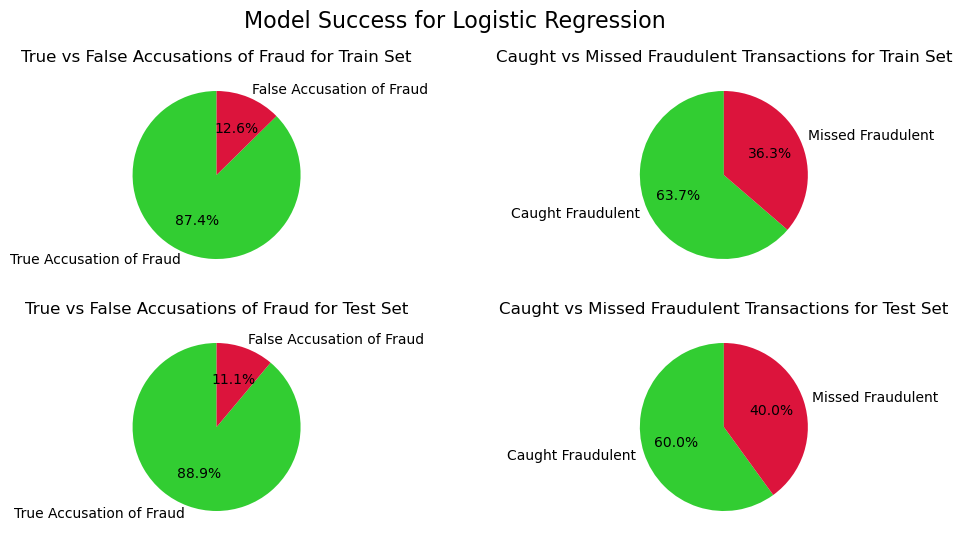

In [17]:
lr_model, lr_train_metrics, lr_test_metrics, lr_predictions = trainer.train_model("logistic_regression", df_train, df_test)


print("Train Metrics:")
for key, value in lr_train_metrics.items():
    print(f"{key}: {value}")

print("\nTest Metrics:")
for key, value in lr_test_metrics.items():
    print(f"{key}: {value}")


trainer.plot_fraudulent_pie_chart(lr_model, lr_predictions)

### Random Forest

Train Metrics:
False Positive Rate (Label 0): 0.014925373134328358
False Positive Rate (Label 1): 4.391434945282721e-06
True Positive Rate (Label 0): 0.9999956085650548
True Positive Rate (Label 1): 0.9850746268656716
Precision (Label 0): 0.9999736519688567
Precision (Label 1): 0.9974811083123426
Recall (Label 0): 0.9999956085650548
Recall (Label 1): 0.9850746268656716
F-measure (Label 0): 0.9999846301464308
F-measure (Label 1): 0.9912390488110139
Accuracy: 0.9999693141268993
Weighted False Positive Rate: 0.014899078696172878
Weighted True Positive Rate: 0.9999693141268993
Weighted F-measure: 0.9999692182819709
Weighted Precision: 0.9999692594941292
Weighted Recall: 0.9999693141268993

Test Metrics:
true_positive: 63
false_positive: 7
false_negative: 17
true_negative: 53879
precision: 0.9
recall: 0.7875


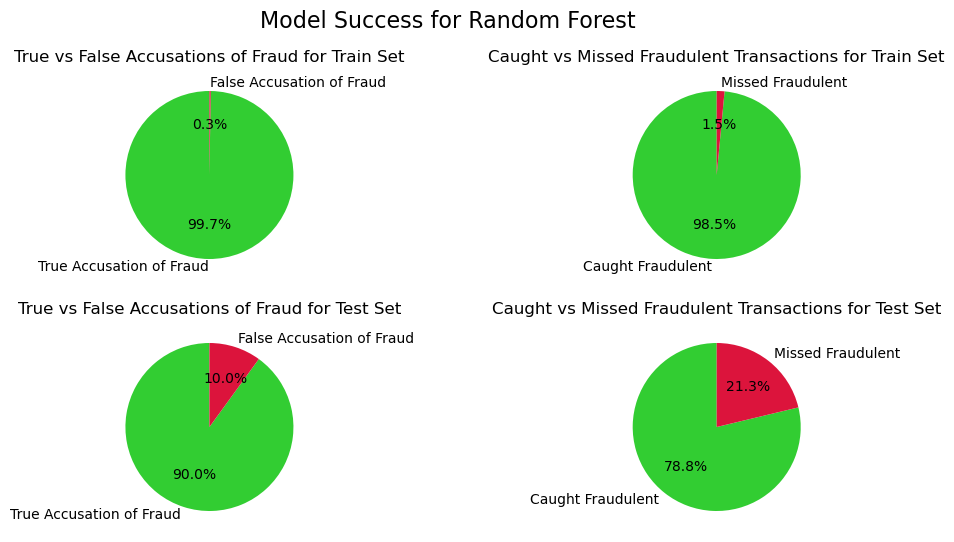

In [18]:
rf_model, rf_train_metrics, rf_test_metrics, rf_predictions = trainer.train_model("random_forest", df_train, df_test)


print("Train Metrics:")
for key, value in rf_train_metrics.items():
    print(f"{key}: {value}")

print("\nTest Metrics:")
for key, value in rf_test_metrics.items():
    print(f"{key}: {value}")


trainer.plot_fraudulent_pie_chart(rf_model, rf_predictions)

In [33]:
lr_params = ['regParam', 'elasticNetParam', 'maxIter', 'tol', 'threshold']

for param_name in lr_params:
    param_value = lr_model.getOrDefault(param_name)
    print(f"{param_name}: {param_value}")

regParam: 0.0
elasticNetParam: 0.5
maxIter: 80
tol: 1.1e-06
threshold: 0.45


In [37]:
rf_params = ["maxDepth", "numTrees"]

for param_name in rf_params:
    param_value = rf_model.getOrDefault(param_name)
    print(f"{param_name}: {param_value}")

maxDepth: 15
numTrees: 26
